In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import trange
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score,  mean_absolute_error
import seaborn as sns

In [2]:
data = pd.read_csv("signal_taus.csv")

In [3]:
data = data.drop(columns = ['Unnamed: 0','BsTauTau_tau_dr1', 'BsTauTau_tau_dr2', 'BsTauTau_tau_dr3','BsTauTau_tau_ptres1', 'BsTauTau_tau_ptres2', 'BsTauTau_tau_ptres3'])

In [4]:
data.columns

Index(['label_tau_px', 'label_tau_py', 'label_tau_pz', 'label_tau_abs',
       'pi1_px', 'pi1_py', 'pi1_pz', 'pi2_px', 'pi2_py', 'pi2_pz', 'pi3_px',
       'pi3_py', 'pi3_pz', 'level_0', 'index', 'BsTauTau_tau_pt',
       'BsTauTau_tau_eta', 'BsTauTau_tau_phi', 'BsTauTau_tau_pi1_dnn',
       'BsTauTau_tau_pi2_dnn', 'BsTauTau_tau_pi3_dnn', 'BsTauTau_tau_pi1_pt',
       'BsTauTau_tau_pi1_eta', 'BsTauTau_tau_pi1_phi', 'BsTauTau_tau_pi2_pt',
       'BsTauTau_tau_pi2_eta', 'BsTauTau_tau_pi2_phi', 'BsTauTau_tau_pi3_pt',
       'BsTauTau_tau_pi3_eta', 'BsTauTau_tau_pi3_phi', 'eventID'],
      dtype='object')

## regression to eta-phi-coordinates

In [5]:
labels = data[['BsTauTau_tau_pt', 'BsTauTau_tau_eta', 'BsTauTau_tau_phi']]
data = data.drop(columns=['BsTauTau_tau_pt', 'BsTauTau_tau_eta', 'BsTauTau_tau_phi',
                          'label_tau_px', 'label_tau_py','label_tau_pz', 'label_tau_abs' ])

In [6]:
indices = np.arange(len(data))
X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(data, labels,indices, test_size=0.3, shuffle = True, random_state=42)

In [7]:
def train_on_cpu():  
    model = CatBoostRegressor(iterations=10000,  learning_rate=0.03,  objective="MultiRMSE")
    model.fit(X_train, y_train,   eval_set=(X_test, y_test),   verbose=1000 )
    return model

model = train_on_cpu()

0:	learn: 11.8278398	test: 11.5986051	best: 11.5986051 (0)	total: 77.6ms	remaining: 12m 56s
1000:	learn: 0.2838276	test: 1.2298469	best: 1.2298469 (1000)	total: 11.3s	remaining: 1m 41s
2000:	learn: 0.1566000	test: 1.2072332	best: 1.2072328 (1999)	total: 23.8s	remaining: 1m 35s
3000:	learn: 0.1049211	test: 1.2032004	best: 1.2031819 (2997)	total: 36.2s	remaining: 1m 24s
4000:	learn: 0.0759365	test: 1.2013565	best: 1.2013414 (3994)	total: 47.9s	remaining: 1m 11s
5000:	learn: 0.0565670	test: 1.2005987	best: 1.2005949 (4993)	total: 59.6s	remaining: 59.6s
6000:	learn: 0.0429984	test: 1.2003750	best: 1.2003518 (5975)	total: 1m 10s	remaining: 47.1s
7000:	learn: 0.0333213	test: 1.2001140	best: 1.2000994 (6905)	total: 1m 23s	remaining: 35.8s
8000:	learn: 0.0260699	test: 1.1999370	best: 1.1999365 (7998)	total: 1m 36s	remaining: 24s
9000:	learn: 0.0205224	test: 1.1998852	best: 1.1998852 (9000)	total: 1m 48s	remaining: 12.1s
9999:	learn: 0.0163600	test: 1.1998062	best: 1.1997903 (9842)	total: 2m 11

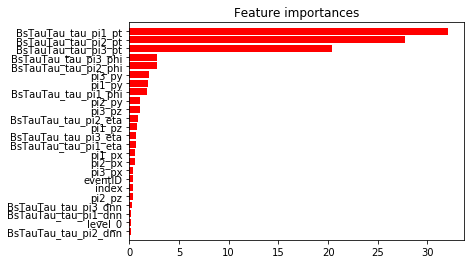

In [8]:
# Plot the feature importances 
importances = model.get_feature_importance()
index = np.argsort(importances)
importances = importances[index]
indices = list(data.columns)
indices = np.asarray(indices)[index]

plt.figure()
plt.rcParams['figure.figsize'] = [3, 4]
plt.title("Feature importances")
plt.barh(range(importances.shape[0]), importances, color="r", align="center")
plt.yticks(range(importances.shape[0]), indices)
plt.ylim([-1, importances.shape[0]])
plt.show()

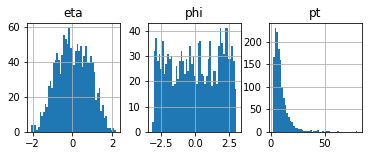

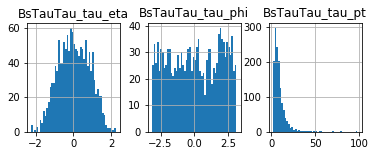

In [9]:
preds = model.predict(X_test)
preds_df = pd.DataFrame(columns=["pt","eta","phi"], data = preds)
preds_df.hist(bins = 50, layout = (1,3), figsize = (6,2) );
labels.iloc[index_test].hist(bins = 50, layout = (1,3), figsize = (6,2) );

In [10]:
# metric mse
mean_squared_error(labels.iloc[index_test], preds_df), r2_score(labels.iloc[index_test], preds_df, multioutput= "uniform_average")

(0.4798323013605695, 0.9770508678883082)

In [11]:
model.save_model("eta_phi_nonscaled.cbm")

## regression to eta-phi-coordinates - features/target - scaled

In [12]:
data = pd.read_csv("signal_taus.csv")
data = data.drop(columns = ['Unnamed: 0','BsTauTau_tau_dr1', 'BsTauTau_tau_dr2', 'BsTauTau_tau_dr3','BsTauTau_tau_ptres1', 'BsTauTau_tau_ptres2', 'BsTauTau_tau_ptres3'])

In [13]:
full_labels = data[['BsTauTau_tau_pt', 'BsTauTau_tau_eta', 'BsTauTau_tau_phi',
                         'label_tau_px', 'label_tau_py','label_tau_pz', 'label_tau_abs' ]]
target_labels = data[['BsTauTau_tau_pt', 'BsTauTau_tau_eta', 'BsTauTau_tau_phi']]
data = data.drop(columns=['BsTauTau_tau_pt', 'BsTauTau_tau_eta', 'BsTauTau_tau_phi',
                         'label_tau_px', 'label_tau_py','label_tau_pz', 'label_tau_abs' ])

In [14]:
def scale_features_target(data,target_labels):
    scaler_features = StandardScaler()
    scaler_features.fit(data.values)
    data = pd.DataFrame(scaler_features.transform(data.values), columns=data.columns, index=data.index)
    
    scaler_targets = StandardScaler()
    scaler_targets.fit(target_labels)
    target_labels = pd.DataFrame(scaler_targets.transform(target_labels.values), columns=target_labels.columns, index=target_labels.index)    
    return data, target_labels, scaler_features, scaler_targets
data, target_labels, scaler_features, scaler_targets = scale_features_target(data,target_labels)

In [15]:
indices = np.arange(len(data))
X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(data, target_labels,indices, test_size=0.3, shuffle = True, random_state=42)

In [16]:
def train_on_cpu():  
    model = CatBoostRegressor(iterations=50000,  learning_rate=0.03 ,  objective="MultiRMSE")
    model.fit(X_train, y_train,   eval_set=(X_test, y_test),   verbose=10000 )
    return model

model = train_on_cpu()

0:	learn: 1.6947419	test: 1.7010554	best: 1.7010554 (0)	total: 58.4ms	remaining: 48m 40s
10000:	learn: 0.0059200	test: 0.2531663	best: 0.2531661 (9999)	total: 5m 21s	remaining: 21m 23s
20000:	learn: 0.0008103	test: 0.2530844	best: 0.2530843 (19984)	total: 10m 21s	remaining: 15m 32s
30000:	learn: 0.0001359	test: 0.2530801	best: 0.2530801 (28544)	total: 15m 13s	remaining: 10m 9s
40000:	learn: 0.0000243	test: 0.2530794	best: 0.2530794 (39633)	total: 18m 33s	remaining: 4m 38s
49999:	learn: 0.0000045	test: 0.2530793	best: 0.2530793 (48556)	total: 21m 30s	remaining: 0us

bestTest = 0.2530793331
bestIteration = 48556

Shrink model to first 48557 iterations.


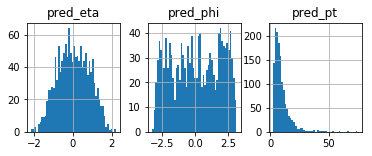

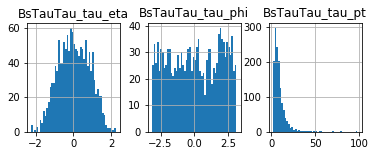

In [17]:
preds = model.predict(X_test)
#descale
preds_descaled = scaler_targets.inverse_transform(preds)
preds_df = pd.DataFrame(columns=["pred_pt","pred_eta","pred_phi"], data = preds_descaled)
preds_df.hist(bins = 50, layout = (1,3), figsize = (6,2) );
full_labels.iloc[index_test,:3].hist(bins = 50, layout = (1,3), figsize = (6,2) );

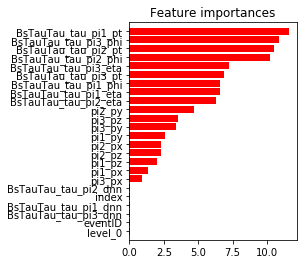

In [18]:
# Plot the feature importances 
importances = model.get_feature_importance()
index = np.argsort(importances)
importances = importances[index]
indices = list(data.columns)
indices = np.asarray(indices)[index]

plt.figure()
plt.rcParams['figure.figsize'] = [3, 4]
plt.title("Feature importances")
plt.barh(range(importances.shape[0]), importances, color="r", align="center")
plt.yticks(range(importances.shape[0]), indices)
plt.ylim([-1, importances.shape[0]])
#plt.show()
plt.savefig("feats1.png")

In [19]:
# scaled
mean_squared_error(target_labels.iloc[index_test], preds), r2_score(target_labels.iloc[index_test], preds, multioutput = "uniform_average") , explained_variance_score(target_labels.iloc[index_test], preds),  mean_absolute_error(target_labels.iloc[index_test], preds)

(0.021349716158086035,
 0.9787124072824726,
 0.9787294610361222,
 0.038106195967480015)

In [20]:
# descaled
mean_squared_error(full_labels.iloc[index_test,:3], preds_df),  r2_score(full_labels.iloc[index_test,:3], preds_df, multioutput = "uniform_average"), explained_variance_score(full_labels.iloc[index_test,:3], preds_df),  mean_absolute_error(full_labels.iloc[index_test,:3], preds_df)

(0.4662008387851107,
 0.9787124072824726,
 0.9787294610361222,
 0.12982996116981582)

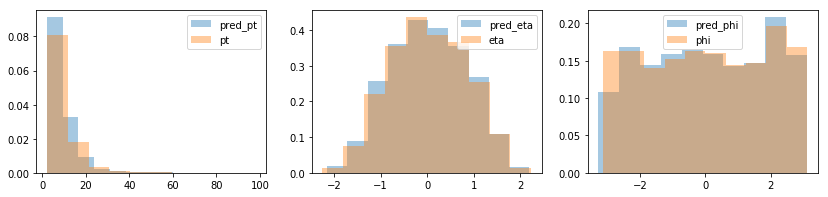

In [22]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
plt.rcParams['figure.figsize'] = [14, 3]
ax1.hist(preds_df.iloc[:,0], density= True, alpha = 0.4, label="pred_pt")
ax1.hist(full_labels.iloc[index_test,0], density= True, alpha = 0.4, label="pt");
ax1.legend();

ax2.hist(preds_df.iloc[:,1], density= True, alpha = 0.4, label="pred_eta")
ax2.hist(full_labels.iloc[index_test,1], density= True, alpha = 0.4, label="eta");
ax2.legend();

ax3.hist(preds_df.iloc[:,2], density= True, alpha = 0.4, label="pred_phi")
ax3.hist(full_labels.iloc[index_test,2], density= True, alpha = 0.4, label="phi");
ax3.legend();

In [23]:
model.save_model("eta_phi_scaled.cbm")

Residual plots

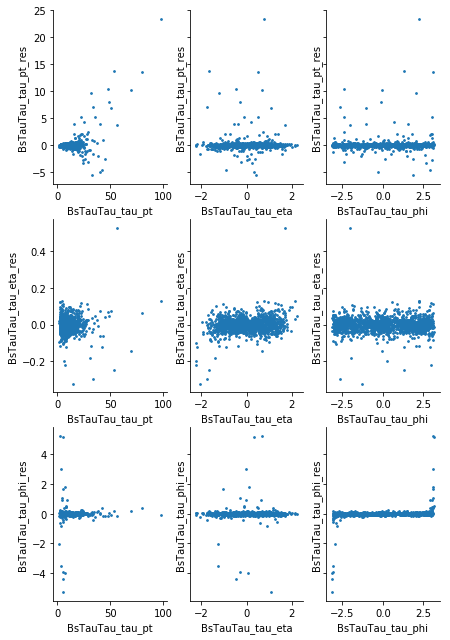

In [24]:
targets = full_labels.iloc[index_test,:3]
preds = preds_df
residuals = targets - preds.values
residuals.columns = ['BsTauTau_tau_pt_res', 'BsTauTau_tau_eta_res', 'BsTauTau_tau_phi_res']
residuals_df = pd.concat((residuals.reset_index(), targets.reset_index()), axis=1)


g = sns.PairGrid(residuals_df, y_vars= ['BsTauTau_tau_pt_res',  'BsTauTau_tau_eta_res', 'BsTauTau_tau_phi_res'], x_vars = ['BsTauTau_tau_pt',  'BsTauTau_tau_eta', 'BsTauTau_tau_phi'], height=3, aspect=0.7)
g = g.map(plt.scatter, s = 3)
plt.subplots_adjust(hspace=0.2, wspace=0.2)

xlabels,ylabels = [],[]

for ax in g.axes[-1,:]:
    xlabel = ax.xaxis.get_label_text()
    xlabels.append(xlabel)
for ax in g.axes[:,0]:
    ylabel = ax.yaxis.get_label_text()
    ylabels.append(ylabel)

for i in range(len(xlabels)):
    for j in range(len(ylabels)):
        g.axes[j,i].tick_params(axis='x',labelbottom = True)
        g.axes[j,i].xaxis.set_label_text(xlabels[i])
        g.axes[j,i].yaxis.set_label_text(ylabels[j])

plt.savefig("s3.png")

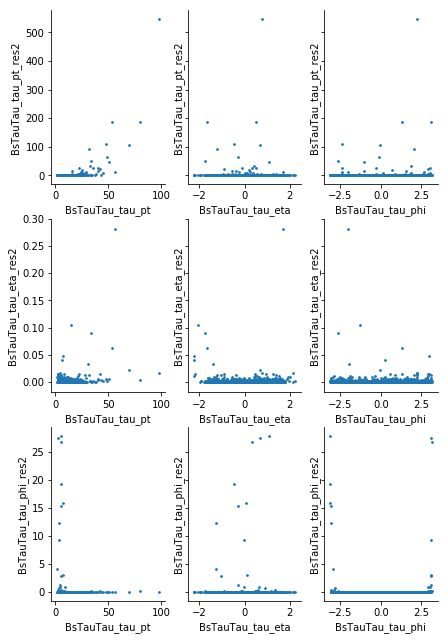

In [25]:
targets = full_labels.iloc[index_test,:3]
preds = preds_df
residuals = (targets - preds.values) ** 2
residuals.columns = ['BsTauTau_tau_pt_res2', 'BsTauTau_tau_eta_res2', 'BsTauTau_tau_phi_res2']
residuals_df = pd.concat((residuals.reset_index(), targets.reset_index()), axis=1)


g = sns.PairGrid(residuals_df, y_vars= ['BsTauTau_tau_pt_res2',  'BsTauTau_tau_eta_res2', 'BsTauTau_tau_phi_res2'], x_vars = ['BsTauTau_tau_pt',  'BsTauTau_tau_eta', 'BsTauTau_tau_phi'], height=3, aspect=0.7)
g = g.map(plt.scatter, s = 3)
plt.subplots_adjust(hspace=0.2, wspace=0.2)

xlabels,ylabels = [],[]

for ax in g.axes[-1,:]:
    xlabel = ax.xaxis.get_label_text()
    xlabels.append(xlabel)
for ax in g.axes[:,0]:
    ylabel = ax.yaxis.get_label_text()
    ylabels.append(ylabel)

for i in range(len(xlabels)):
    for j in range(len(ylabels)):
        g.axes[j,i].tick_params(axis='x',labelbottom = True)
        g.axes[j,i].xaxis.set_label_text(xlabels[i])
        g.axes[j,i].yaxis.set_label_text(ylabels[j])

plt.savefig("s4.png")

## regression to cartesian-coordinates - features/target - not scaled

In [26]:
data = pd.read_csv("signal_taus.csv")
data = data.drop(columns = ['Unnamed: 0','BsTauTau_tau_dr1', 'BsTauTau_tau_dr2', 'BsTauTau_tau_dr3','BsTauTau_tau_ptres1', 'BsTauTau_tau_ptres2', 'BsTauTau_tau_ptres3'])

full_labels = data[['BsTauTau_tau_pt', 'BsTauTau_tau_eta', 'BsTauTau_tau_phi',
                         'label_tau_px', 'label_tau_py','label_tau_pz', 'label_tau_abs' ]]
target_labels = data[['label_tau_px', 'label_tau_py','label_tau_pz']]
data = data.drop(columns=['BsTauTau_tau_pt', 'BsTauTau_tau_eta', 'BsTauTau_tau_phi',
                         'label_tau_px', 'label_tau_py','label_tau_pz', 'label_tau_abs' ])

In [27]:
indices = np.arange(len(data))
X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(data, target_labels,indices, test_size=0.3, shuffle = True, random_state=42)

In [28]:
def train_on_cpu():  
    model = CatBoostRegressor(iterations=20000,  learning_rate=0.03 ,  objective="MultiRMSE")
    model.fit(X_train, y_train,   eval_set=(X_test, y_test),   verbose=5000 )
    return model

model = train_on_cpu()

0:	learn: 17.5345602	test: 16.9943848	best: 16.9943848 (0)	total: 17.4ms	remaining: 5m 48s
5000:	learn: 0.1839185	test: 3.9852317	best: 3.9852317 (5000)	total: 1m 6s	remaining: 3m 18s
10000:	learn: 0.0561095	test: 3.9804294	best: 3.9804257 (9998)	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.0199008	test: 3.9795588	best: 3.9795559 (14979)	total: 3m 7s	remaining: 1m 2s
19999:	learn: 0.0075581	test: 3.9793003	best: 3.9792998 (19993)	total: 4m	remaining: 0us

bestTest = 3.979299817
bestIteration = 19993

Shrink model to first 19994 iterations.


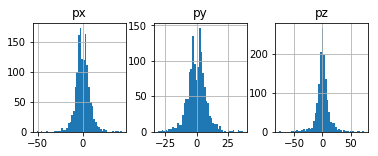

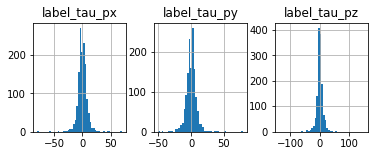

In [29]:
preds = model.predict(X_test)
preds_df = pd.DataFrame(columns=["px","py","pz"], data = preds)
preds_df.hist(bins = 50, layout = (1,3), figsize = (6,2) );
y_test.hist(bins = 50, layout = (1,3), figsize = (6,2) );

In [30]:
y_test.shape,  preds_df.shape, preds_df.columns

((1380, 3), (1380, 3), Index(['px', 'py', 'pz'], dtype='object'))

In [31]:
# mse in cartesian coordinates
mean_squared_error(y_test, preds_df),  r2_score(y_test, preds_df, multioutput="uniform_average"), explained_variance_score(y_test, preds_df),  mean_absolute_error(y_test, preds_df)

(5.278275535758737, 0.9536887553276173, 0.9536928169948006, 0.4700852139720159)

In [32]:
model.save_model("cartesian_nonscaled.cbm")

In [33]:
# mse in eta-phi coordinates
def to_eta_phi(preds_df):
    # we need atan2 and not arctan
    preds_df.insert(0,"pred_tau_phi", np.arctan2(preds_df.py, preds_df.px))
    preds_df.insert(1, "pred_tau_pt", pd.eval(" preds_df.px/ cos(preds_df.pred_tau_phi) "))
    preds_df.insert(2, "pred_tau_eta", pd.eval(" arcsinh(preds_df.pz/ preds_df.pred_tau_pt) "))
    return preds_df

original_test = full_labels.loc[index_test,['BsTauTau_tau_pt', 'BsTauTau_tau_eta', 'BsTauTau_tau_phi']]
preds_eta_phi = to_eta_phi(preds_df)[["pred_tau_pt","pred_tau_eta","pred_tau_phi"]]
mean_squared_error(original_test, preds_eta_phi),  r2_score(original_test, preds_eta_phi,multioutput="uniform_average"), explained_variance_score(original_test, preds_eta_phi),  mean_absolute_error(original_test, preds_eta_phi)

(1.2179175159774929,
 0.9705388073865239,
 0.9707190132927184,
 0.1659773572106236)

## regression to cartesian-coordinates - features/target - scaled

In [34]:
data = pd.read_csv("signal_taus.csv")
data = data.drop(columns = ['Unnamed: 0','BsTauTau_tau_dr1', 'BsTauTau_tau_dr2', 'BsTauTau_tau_dr3','BsTauTau_tau_ptres1', 'BsTauTau_tau_ptres2', 'BsTauTau_tau_ptres3'])

full_labels = data[['BsTauTau_tau_pt', 'BsTauTau_tau_eta', 'BsTauTau_tau_phi',
                         'label_tau_px', 'label_tau_py','label_tau_pz', 'label_tau_abs' ]]
target_labels = data[['label_tau_px', 'label_tau_py','label_tau_pz']]
data = data.drop(columns=['BsTauTau_tau_pt', 'BsTauTau_tau_eta', 'BsTauTau_tau_phi',
                         'label_tau_px', 'label_tau_py','label_tau_pz', 'label_tau_abs' ])

In [35]:
data, target_labels, scaler_features, scaler_targets = scale_features_target(data,target_labels)

In [36]:
indices = np.arange(len(data))
X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(data, target_labels,indices, test_size=0.3, shuffle = True, random_state=42)

In [37]:
def train_on_cpu():  
    model = CatBoostRegressor(iterations=50000,  learning_rate=0.03 ,  objective="MultiRMSE")
    model.fit(X_train, y_train,   eval_set=(X_test, y_test),   verbose=5000 )
    return model

model = train_on_cpu()

0:	learn: 1.7149928	test: 1.6694070	best: 1.6694070 (0)	total: 30ms	remaining: 24m 59s
5000:	learn: 0.0181507	test: 0.3621276	best: 0.3621253 (4996)	total: 57.5s	remaining: 8m 37s
10000:	learn: 0.0055667	test: 0.3616609	best: 0.3616606 (9995)	total: 1m 52s	remaining: 7m 30s
15000:	learn: 0.0019963	test: 0.3615775	best: 0.3615775 (15000)	total: 2m 47s	remaining: 6m 30s
20000:	learn: 0.0007640	test: 0.3615532	best: 0.3615527 (19926)	total: 3m 42s	remaining: 5m 33s
25000:	learn: 0.0003044	test: 0.3615483	best: 0.3615483 (24992)	total: 4m 39s	remaining: 4m 39s
30000:	learn: 0.0001248	test: 0.3615466	best: 0.3615466 (29994)	total: 5m 35s	remaining: 3m 43s
35000:	learn: 0.0000519	test: 0.3615461	best: 0.3615460 (34729)	total: 6m 30s	remaining: 2m 47s
40000:	learn: 0.0000219	test: 0.3615458	best: 0.3615458 (40000)	total: 7m 24s	remaining: 1m 50s
45000:	learn: 0.0000093	test: 0.3615457	best: 0.3615457 (44452)	total: 8m 17s	remaining: 55.3s
49999:	learn: 0.0000040	test: 0.3615457	best: 0.361545

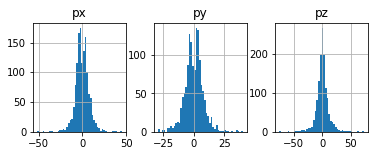

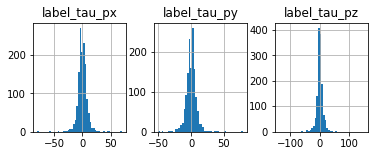

In [38]:
preds = model.predict(X_test)
#descale
preds_descaled = scaler_targets.inverse_transform(preds)
preds_df = pd.DataFrame(columns=["px","py","pz"], data = preds_descaled)
preds_df.hist(bins = 50, layout = (1,3), figsize = (6,2) );
full_labels.loc[index_test,["label_tau_px","label_tau_py","label_tau_pz"]].hist(bins = 50, layout = (1,3), figsize = (6,2) );

In [39]:
model.save_model("cartesian_scaled.cbm")

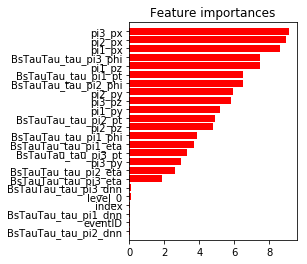

In [41]:
# Plot the feature importances 
importances = model.get_feature_importance()
index = np.argsort(importances)
importances = importances[index]
indices = list(data.columns)
indices = np.asarray(indices)[index]

plt.figure()
plt.rcParams['figure.figsize'] = [3, 4]
plt.title("Feature importances")
plt.barh(range(importances.shape[0]), importances, color="r", align="center")
plt.yticks(range(importances.shape[0]), indices)
plt.ylim([-1, importances.shape[0]])
#plt.show()
plt.savefig("s5.png")

In [42]:
original_test = full_labels.loc[index_test,['BsTauTau_tau_pt', 'BsTauTau_tau_eta', 'BsTauTau_tau_phi']]
def to_eta_phi(preds_df):
    # we need atan2 and not arctan
    preds_df.insert(0,"pred_tau_phi", np.arctan2(preds_df.py, preds_df.px))
    preds_df.insert(1, "pred_tau_pt", pd.eval(" preds_df.px/ cos(preds_df.pred_tau_phi) "))
    preds_df.insert(2, "pred_tau_eta", pd.eval(" arcsinh(preds_df.pz/ preds_df.pred_tau_pt) "))
    return preds_df
preds_eta_phi = to_eta_phi(preds_df)[["pred_tau_pt","pred_tau_eta","pred_tau_phi"]]
mean_squared_error(original_test, preds_eta_phi),  r2_score(original_test, preds_eta_phi, multioutput="uniform_average"),explained_variance_score(original_test, preds_eta_phi),  mean_absolute_error(original_test, preds_eta_phi)

(1.1121599302230465,
 0.969867308252264,
 0.9700484213506746,
 0.15952876992198173)

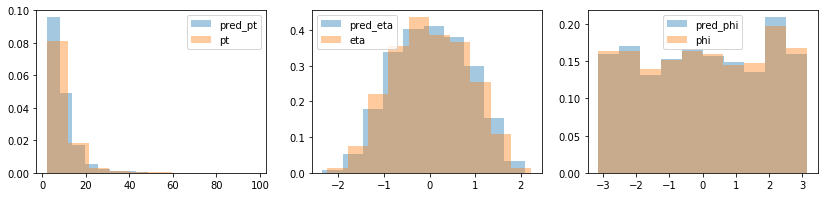

In [44]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
plt.rcParams['figure.figsize'] = [14, 3]
ax1.hist(preds_eta_phi.iloc[:,0], density= True, alpha = 0.4, label="pred_pt")
ax1.hist(original_test.iloc[:,0], density= True, alpha = 0.4, label="pt");
ax1.legend();

ax2.hist(preds_eta_phi.iloc[:,1], density= True, alpha = 0.4, label="pred_eta")
ax2.hist(original_test.iloc[:,1], density= True, alpha = 0.4, label="eta");
ax2.legend();

ax3.hist(preds_eta_phi.iloc[:,2], density= True, alpha = 0.4, label="pred_phi")
ax3.hist(original_test.iloc[:,2], density= True, alpha = 0.4, label="phi");
ax3.legend();

Residual plot

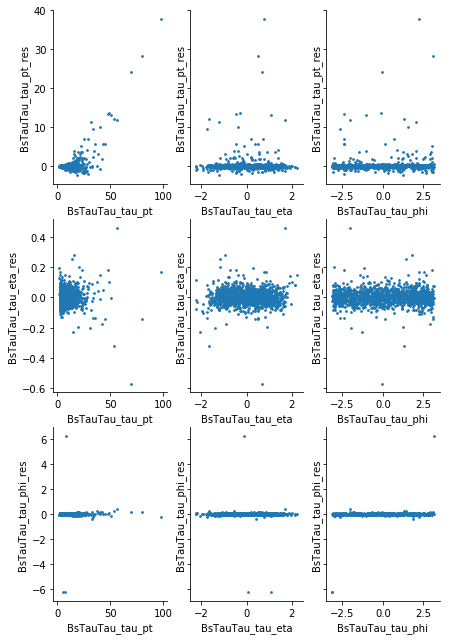

In [45]:
targets = original_test# .iloc[index_test,:3]
preds = preds_eta_phi
residuals = targets - preds.values
residuals.columns = ['BsTauTau_tau_pt_res', 'BsTauTau_tau_eta_res', 'BsTauTau_tau_phi_res']
residuals_df = pd.concat((residuals.reset_index(), targets.reset_index()), axis=1)


g = sns.PairGrid(residuals_df, y_vars= ['BsTauTau_tau_pt_res',  'BsTauTau_tau_eta_res', 'BsTauTau_tau_phi_res'], x_vars = ['BsTauTau_tau_pt',  'BsTauTau_tau_eta', 'BsTauTau_tau_phi'], height=3, aspect=0.7)
g = g.map(plt.scatter, s = 3)
plt.subplots_adjust(hspace=0.2, wspace=0.2)

xlabels,ylabels = [],[]

for ax in g.axes[-1,:]:
    xlabel = ax.xaxis.get_label_text()
    xlabels.append(xlabel)
for ax in g.axes[:,0]:
    ylabel = ax.yaxis.get_label_text()
    ylabels.append(ylabel)

for i in range(len(xlabels)):
    for j in range(len(ylabels)):
        g.axes[j,i].tick_params(axis='x',labelbottom = True)
        g.axes[j,i].xaxis.set_label_text(xlabels[i])
        g.axes[j,i].yaxis.set_label_text(ylabels[j])

plt.savefig("s5.png")

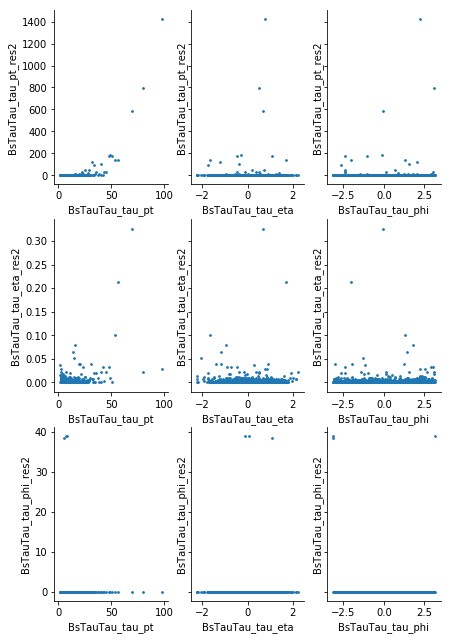

In [46]:
targets = original_test# .iloc[index_test,:3]
preds = preds_eta_phi
residuals = (targets - preds.values) ** 2
residuals.columns = ['BsTauTau_tau_pt_res2', 'BsTauTau_tau_eta_res2', 'BsTauTau_tau_phi_res2']
residuals_df = pd.concat((residuals.reset_index(), targets.reset_index()), axis=1)


g = sns.PairGrid(residuals_df, y_vars= ['BsTauTau_tau_pt_res2',  'BsTauTau_tau_eta_res2', 'BsTauTau_tau_phi_res2'], x_vars = ['BsTauTau_tau_pt',  'BsTauTau_tau_eta', 'BsTauTau_tau_phi'], height=3, aspect=0.7)
g = g.map(plt.scatter, s = 3)
plt.subplots_adjust(hspace=0.2, wspace=0.2)

xlabels,ylabels = [],[]

for ax in g.axes[-1,:]:
    xlabel = ax.xaxis.get_label_text()
    xlabels.append(xlabel)
for ax in g.axes[:,0]:
    ylabel = ax.yaxis.get_label_text()
    ylabels.append(ylabel)

for i in range(len(xlabels)):
    for j in range(len(ylabels)):
        g.axes[j,i].tick_params(axis='x',labelbottom = True)
        g.axes[j,i].xaxis.set_label_text(xlabels[i])
        g.axes[j,i].yaxis.set_label_text(ylabels[j])

plt.savefig("s6.png")